# <font color='Red'>Compare to atmosphere</font>

In [1]:
from modules import *

In [2]:
pixelid = 0
Troom = 16. + 273. # K, cabin temperature
rhdus = fits.open('/Users/karatsu/Desktop/DESHIMA/cosmos_20171024012916/reduced_20171024012916.fits')
ddb = fits.open('/Users/karatsu/work/deshima-dev/database/DDB_20171031.fits')

Tsignal, Psignal = calibrate_to_power(pixelid, Troom, rhdus, ddb)

print(len(Tsignal), len(Tsignal[0]), Tsignal[0], Tsignal[44], Tsignal[46])
print(len(Psignal), len(Psignal[0]), Psignal[0], Psignal[44], Psignal[46])

63 29234 [ 104.27622617  104.21923041  103.80658657 ...,   99.18867503   99.48712086
   98.60713688] [ nan  nan  nan ...,  nan  nan  nan] [ nan  nan  nan ...,  nan  nan  nan]
63 29234 [  2.78113985e-11   2.77998879e-11   2.77165530e-11 ...,   2.67840529e-11
   2.68443123e-11   2.66666367e-11] [ nan  nan  nan ...,  nan  nan  nan] [ nan  nan  nan ...,  nan  nan  nan]


In [3]:
kidname = {}
for i,j in zip(ddb['KIDDES'].data['masterid'],ddb['KIDDES'].data['attribute']):
    kidname[i] = j

kiddict = {}
for i,j in zip(ddb['KIDFILT'].data['kidid'],ddb['KIDFILT'].data['masterid']):
    kiddict[i] = j

print( len(kidname), kidname)
print( len(kiddict), kiddict )

66 {0: 'wideband', 1: 'wideband', 2: 'wideband', 3: 'wideband', 4: 'wideband', 5: 'wideband', 6: 'wideband', 10: 'blind', 11: 'blind', 12: 'blind', 13: 'blind', 14: 'blind', 15: 'blind', 20: 'Al', 21: 'Al', 30: 'NbTiN', 31: 'NbTiN', 100: 'filter', 107: 'filter', 114: 'filter', 121: 'filter', 128: 'filter', 135: 'filter', 142: 'filter', 101: 'filter', 108: 'filter', 115: 'filter', 122: 'filter', 129: 'filter', 136: 'filter', 143: 'filter', 102: 'filter', 109: 'filter', 116: 'filter', 123: 'filter', 130: 'filter', 137: 'filter', 144: 'filter', 103: 'filter', 110: 'filter', 117: 'filter', 124: 'filter', 131: 'filter', 138: 'filter', 145: 'filter', 104: 'filter', 111: 'filter', 118: 'filter', 125: 'filter', 132: 'filter', 139: 'filter', 146: 'filter', 105: 'filter', 112: 'filter', 119: 'filter', 126: 'filter', 133: 'filter', 140: 'filter', 147: 'filter', 106: 'filter', 113: 'filter', 120: 'filter', 127: 'filter', 134: 'filter', 141: 'filter', 148: 'filter'}
63 {0: 0, 1: 3, 2: 1, 3: 4, 4: 2

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

/Users/karatsu/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


disabled: 46


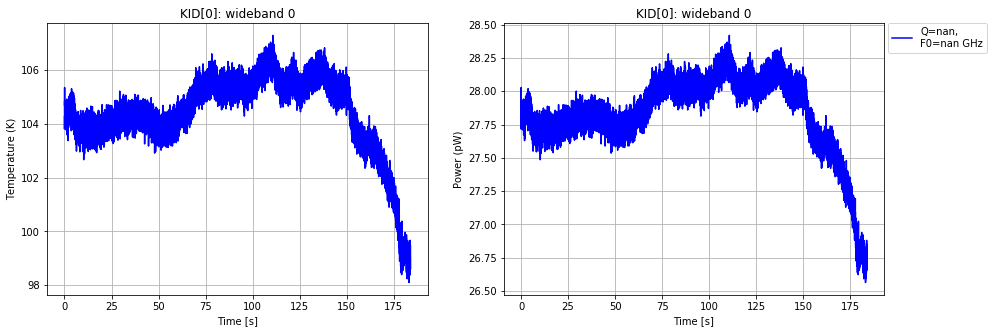

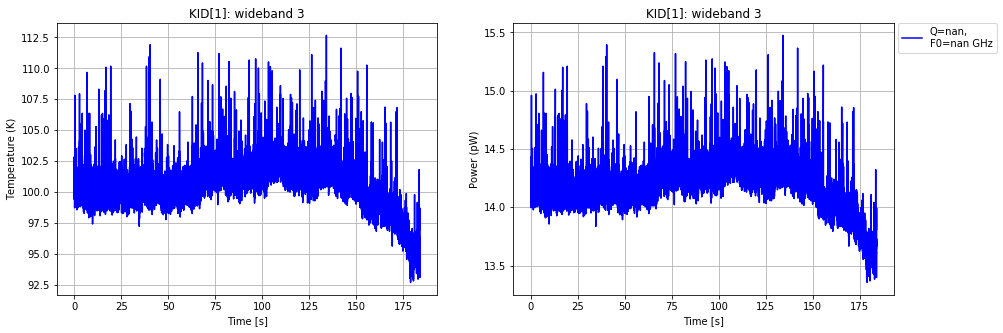

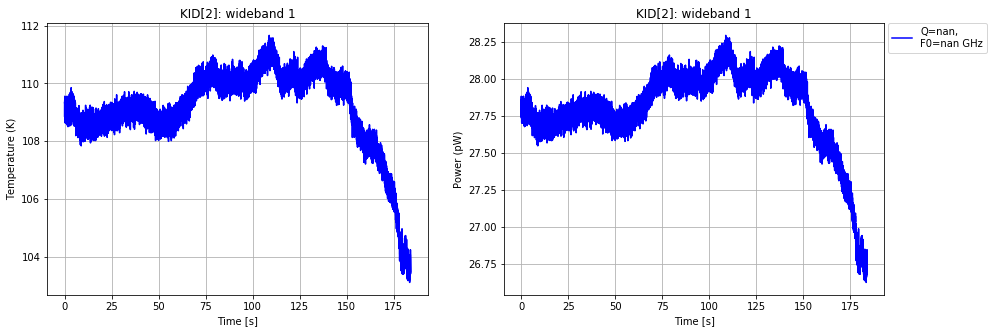

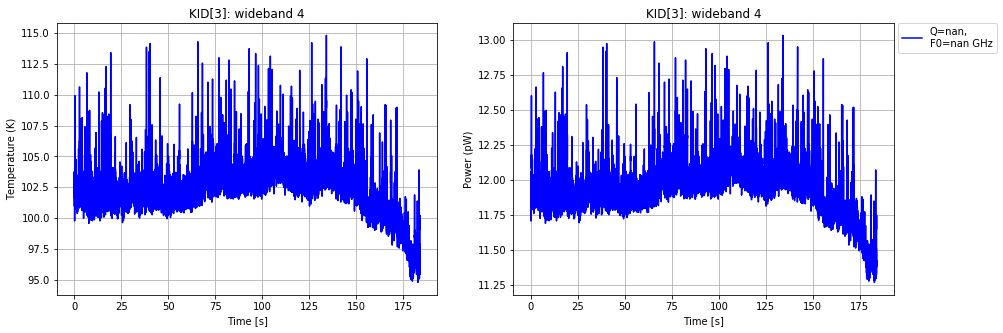

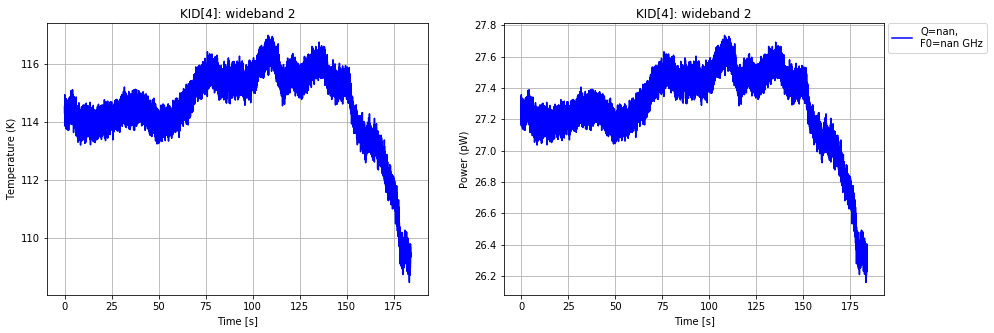

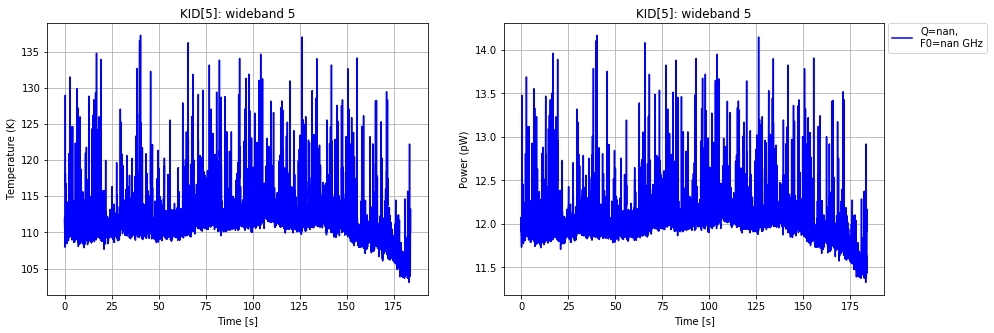

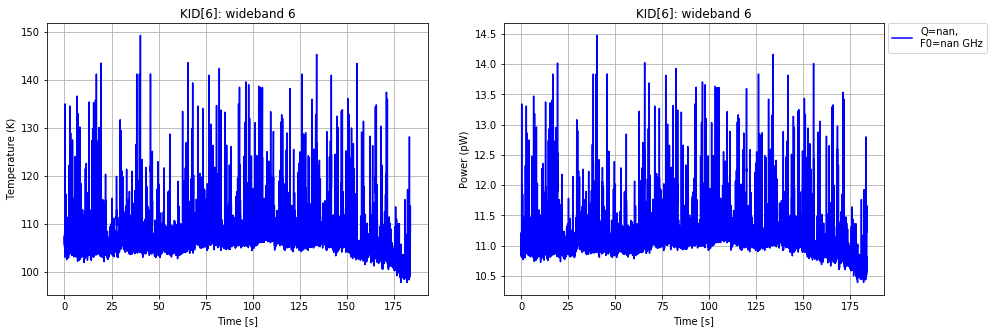

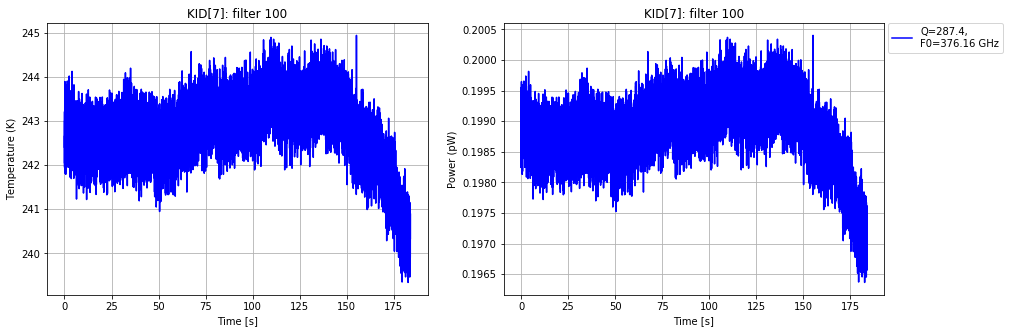

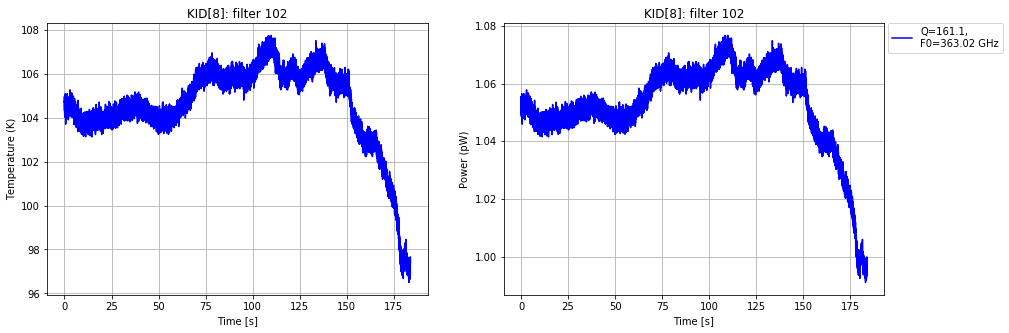

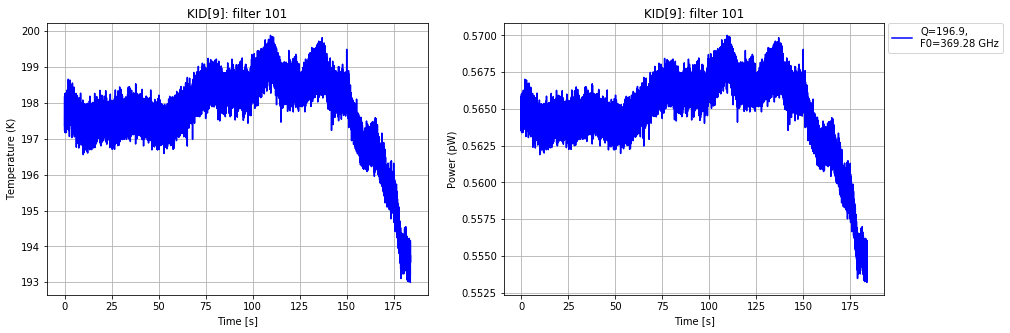

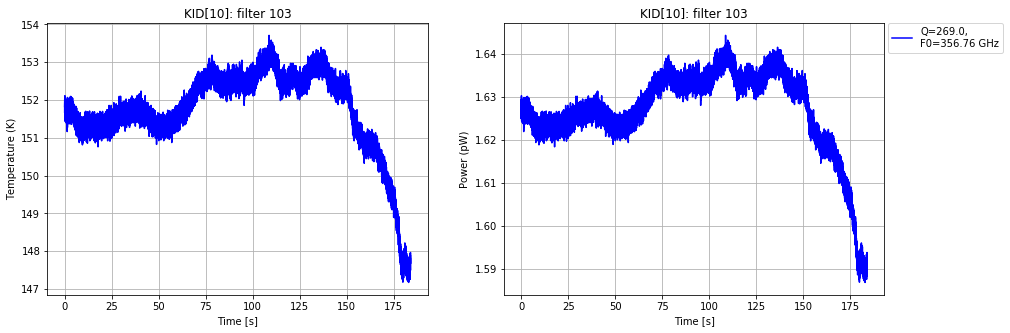

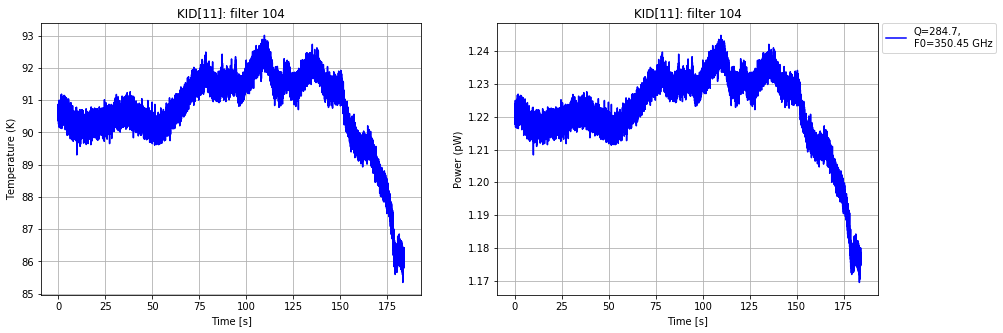

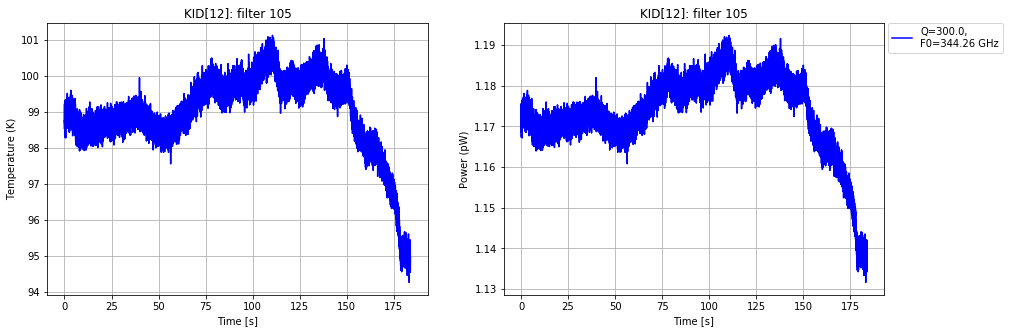

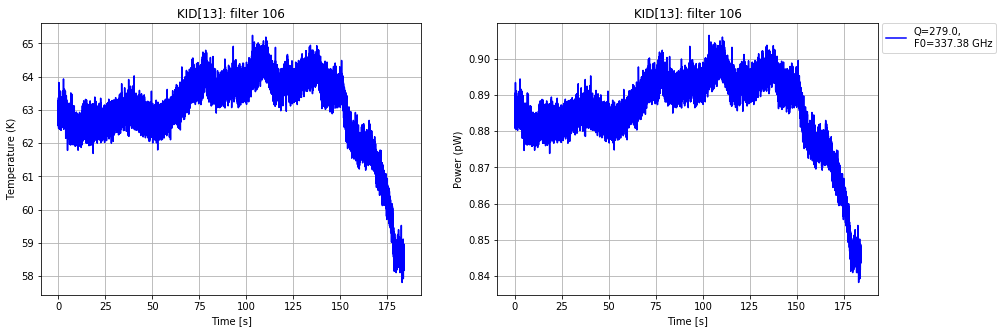

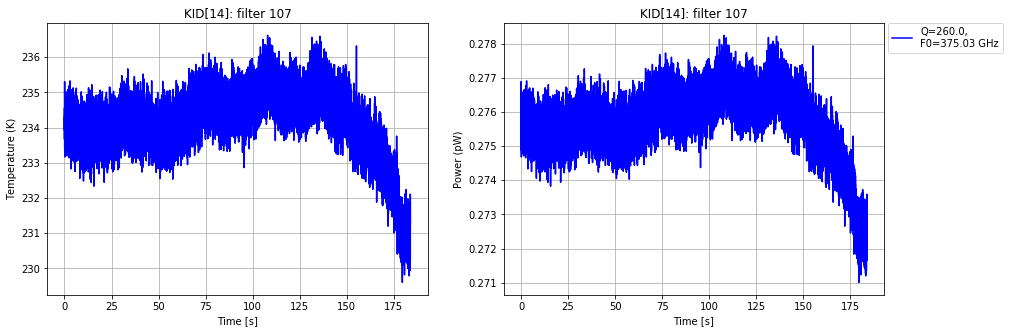

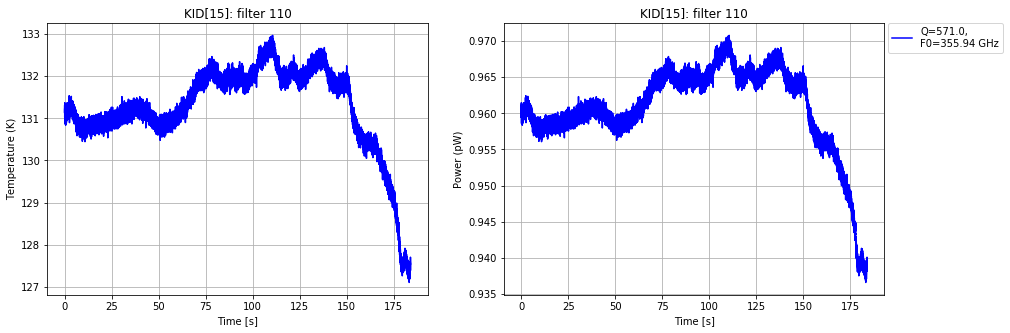

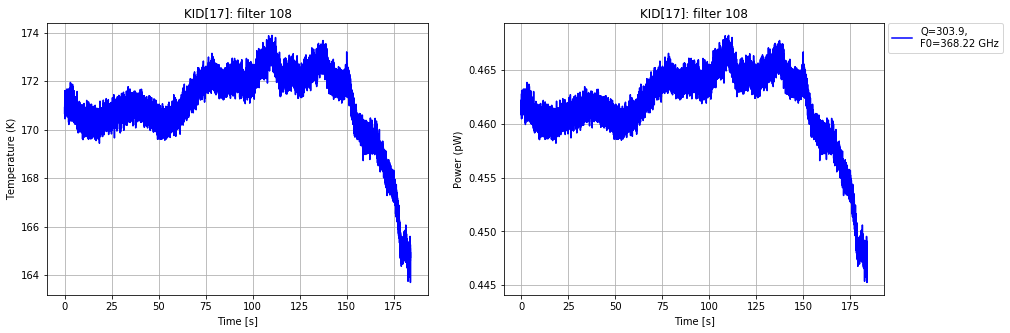

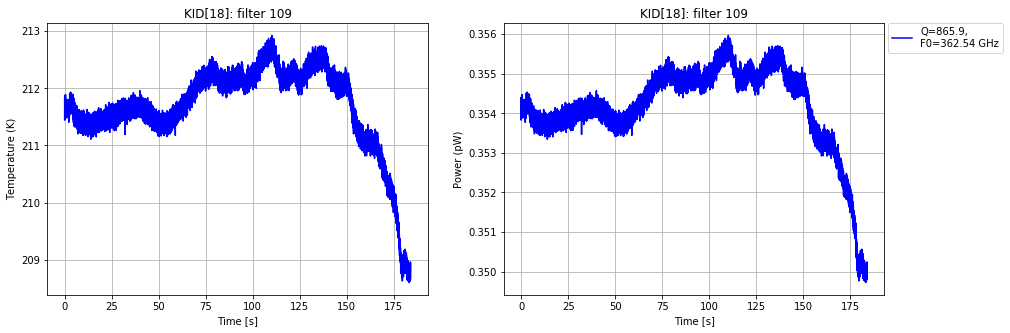

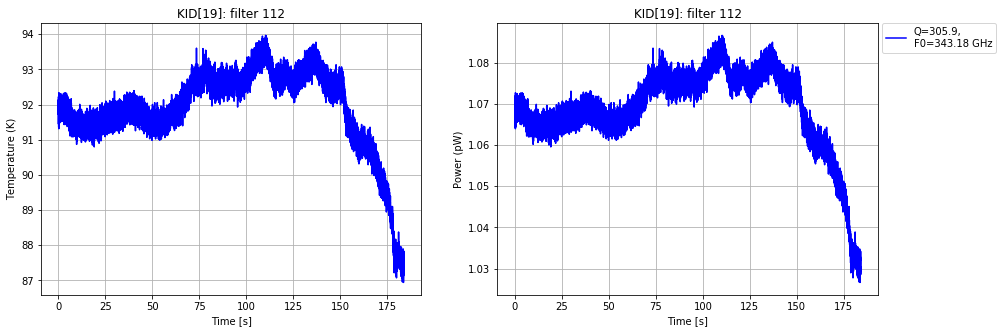

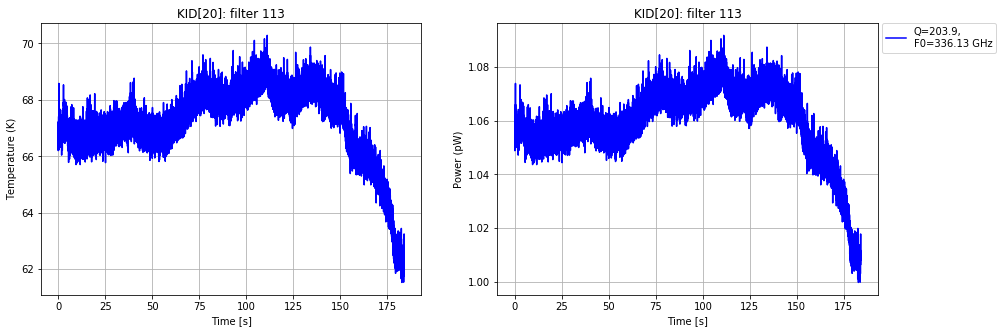

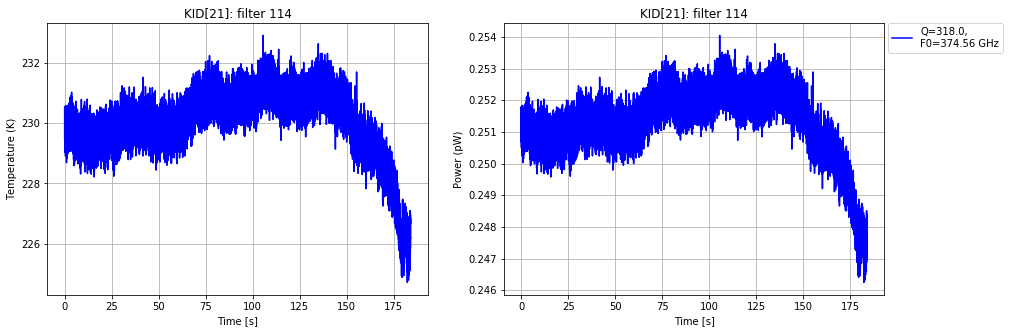

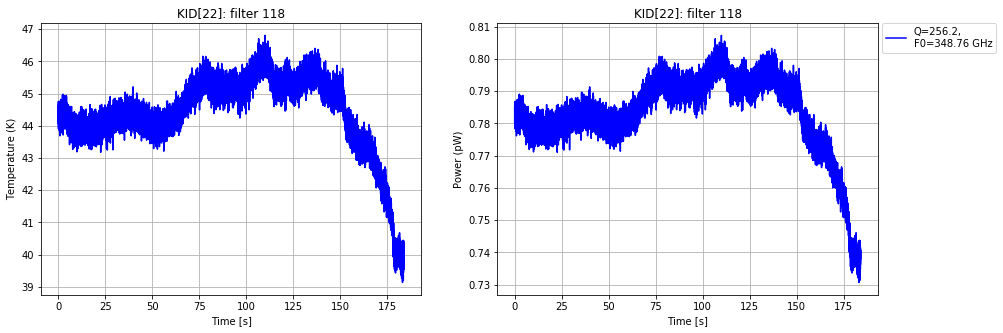

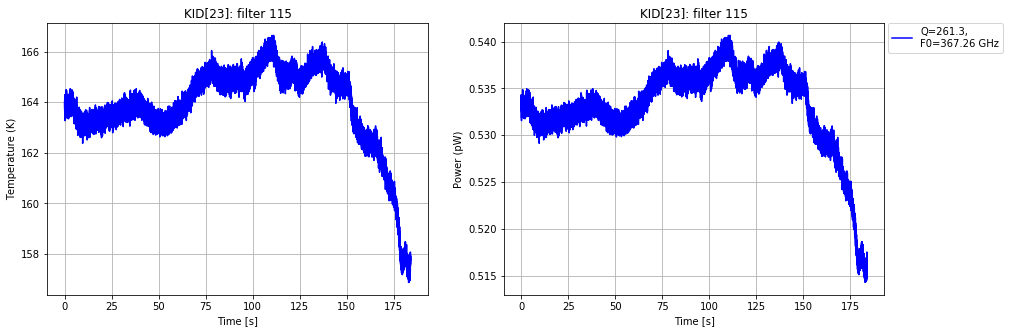

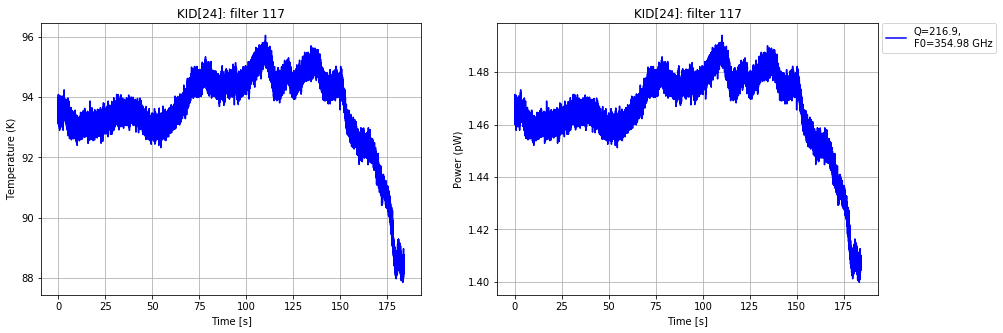

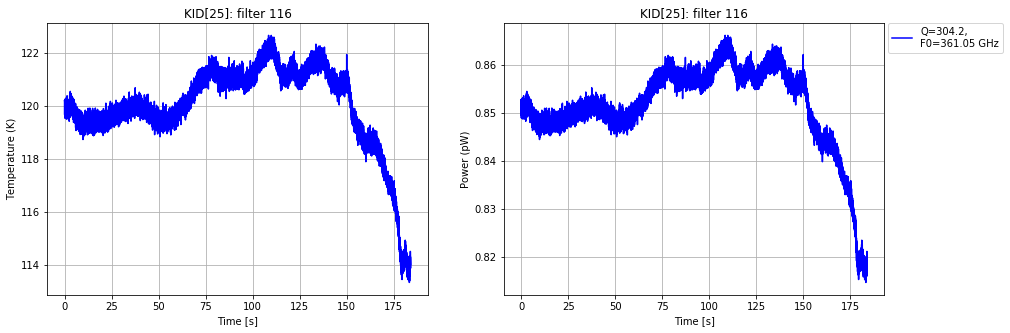

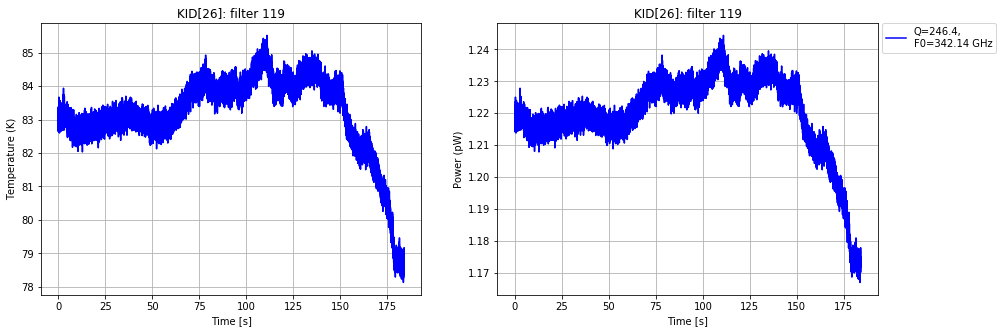

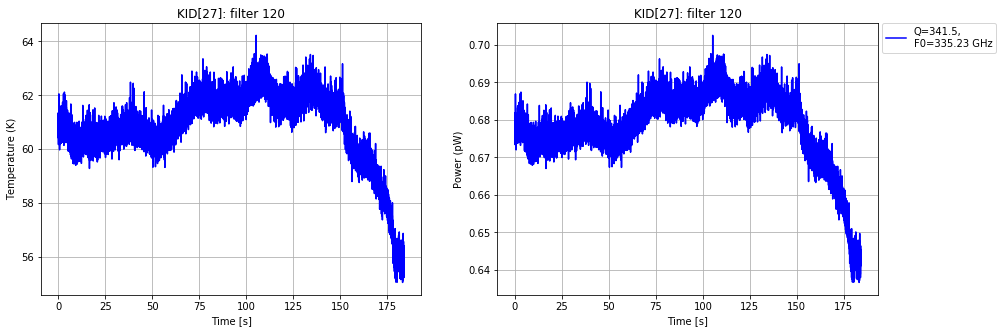

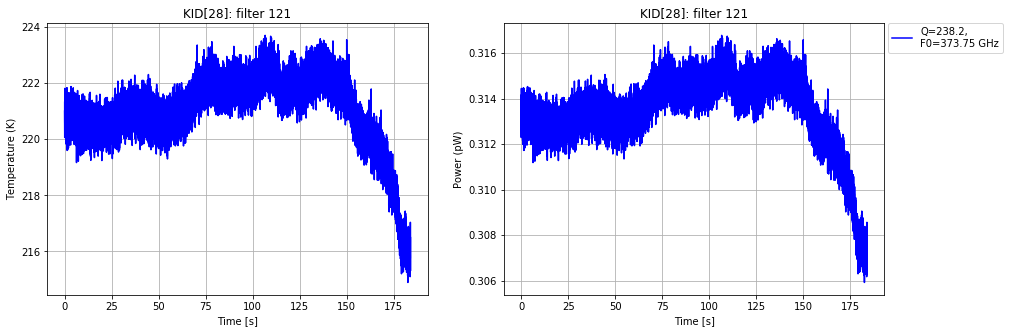

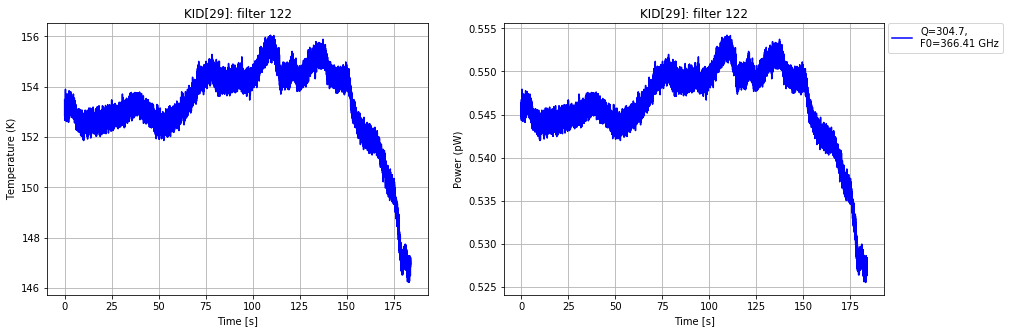

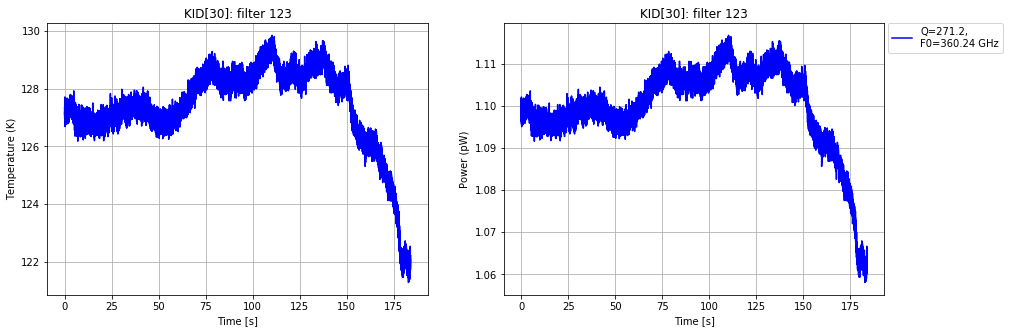

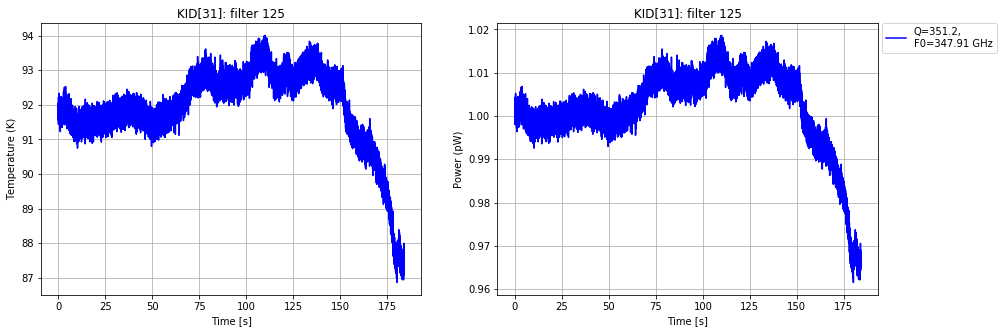

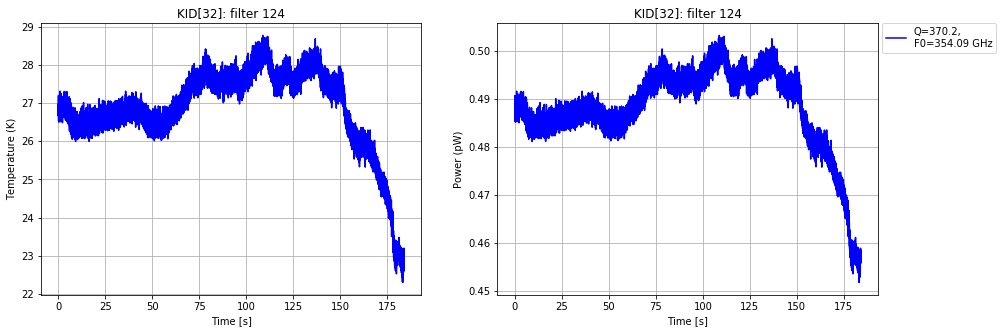

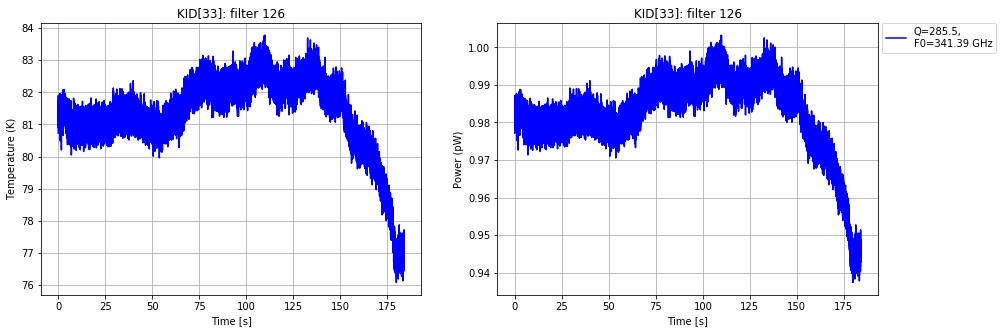

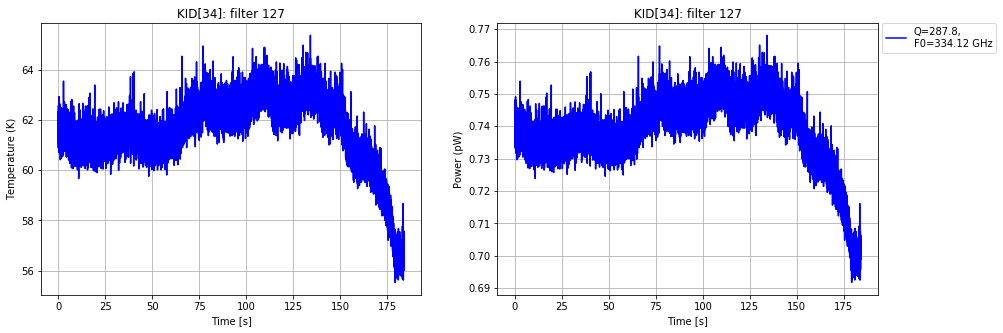

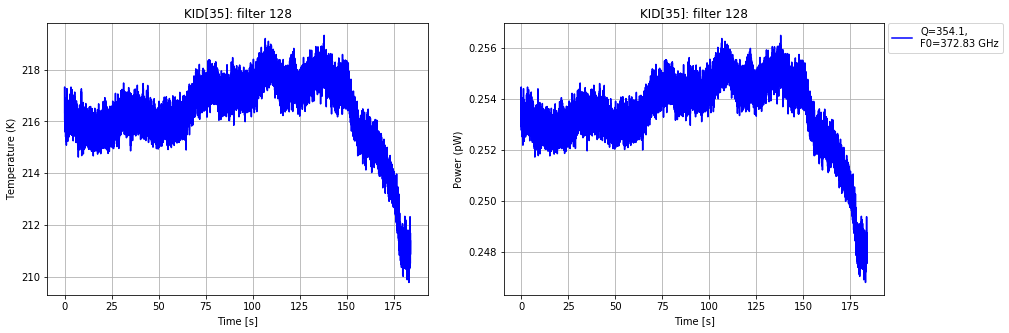

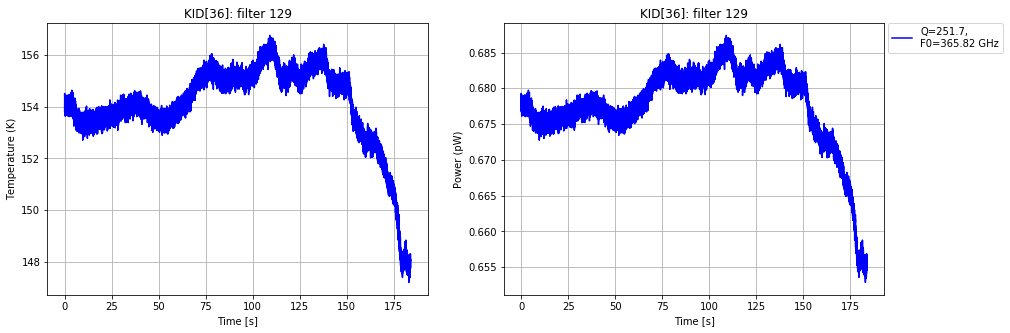

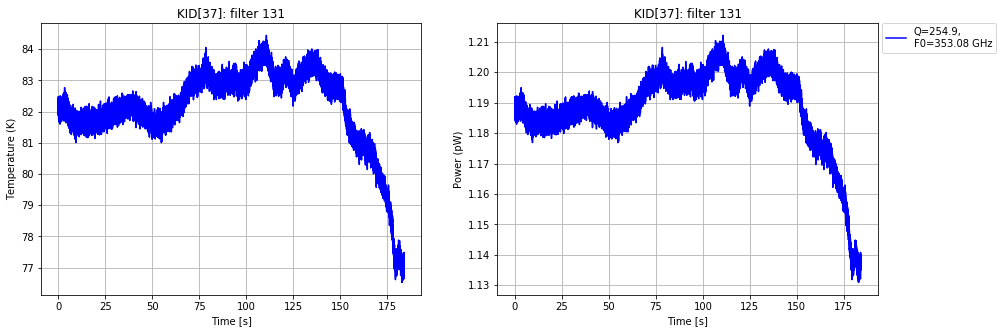

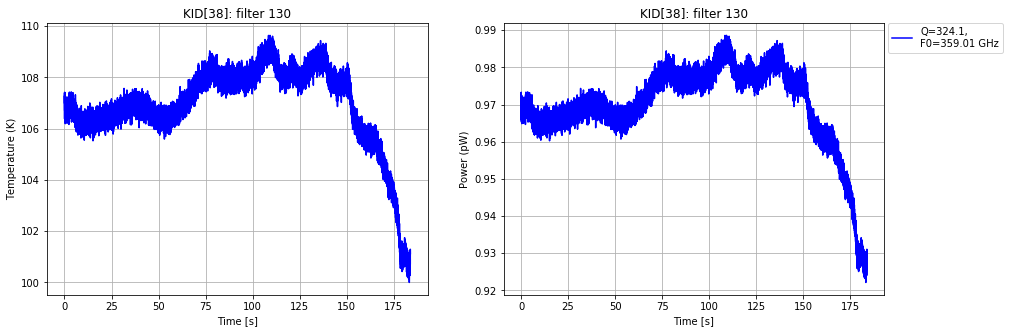

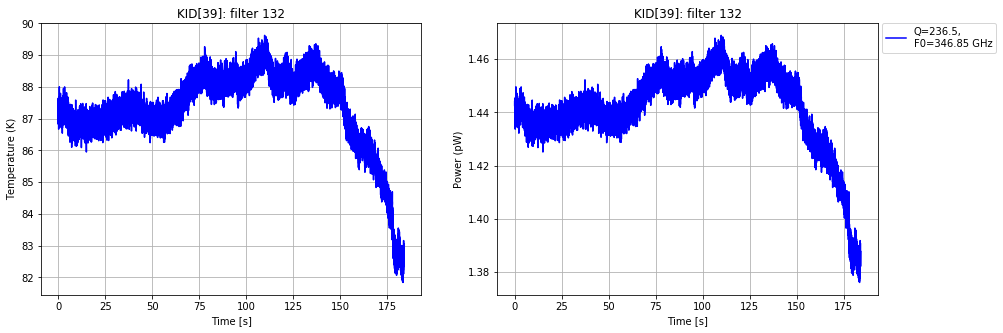

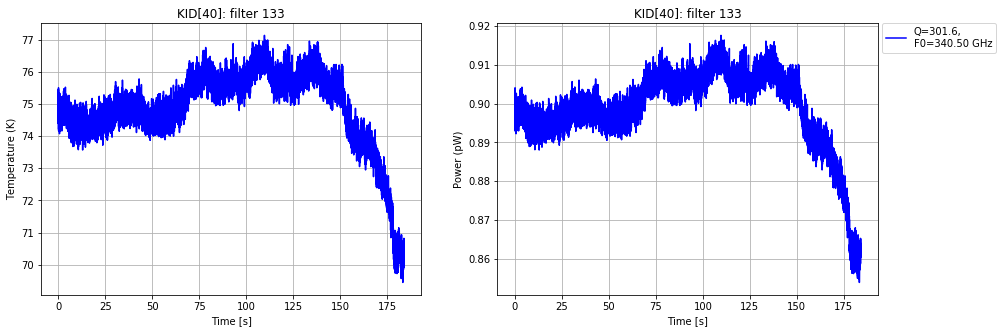

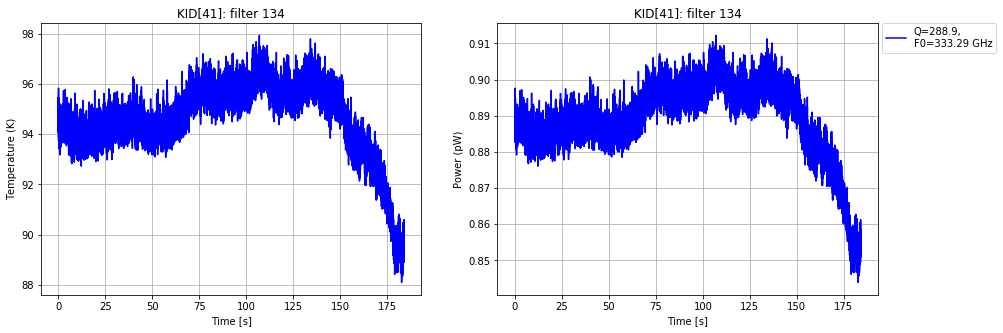

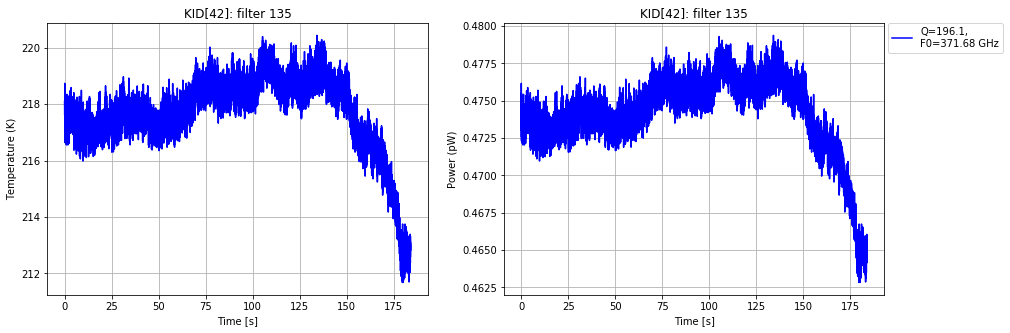

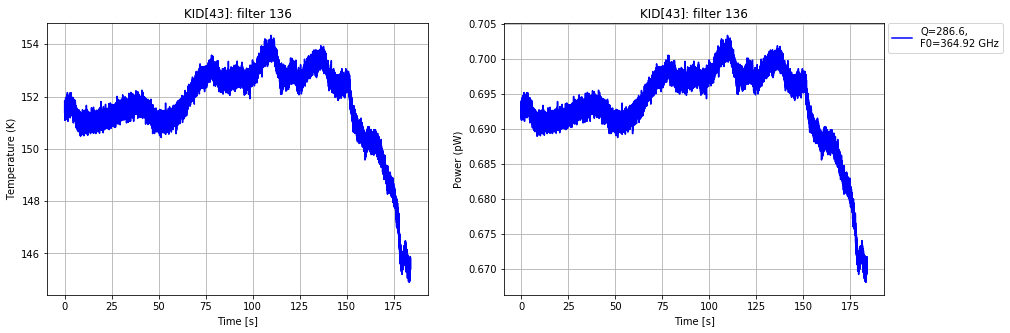

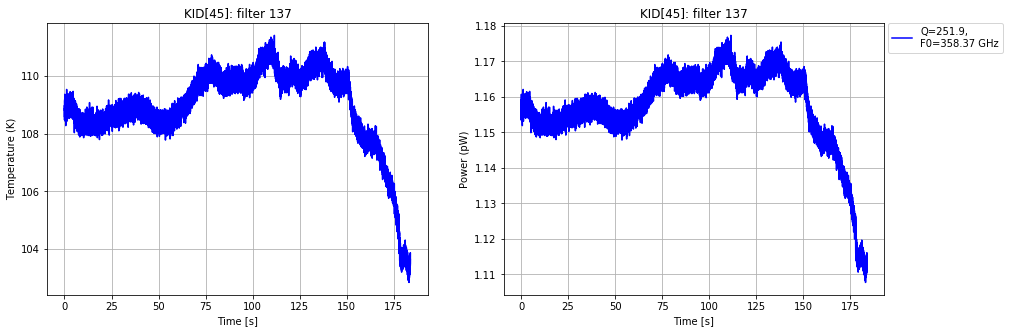

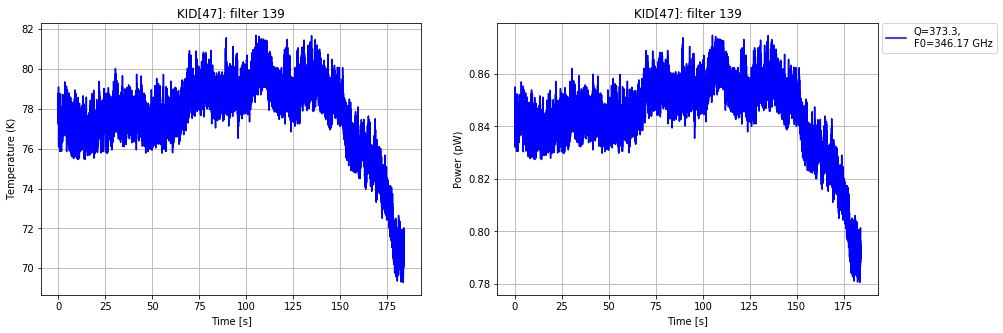

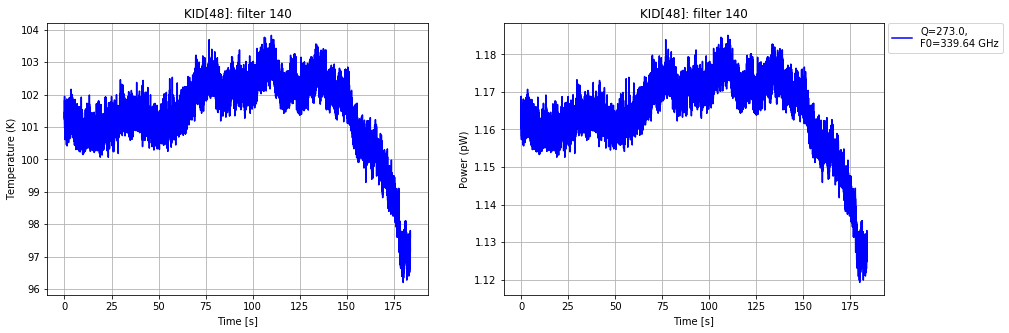

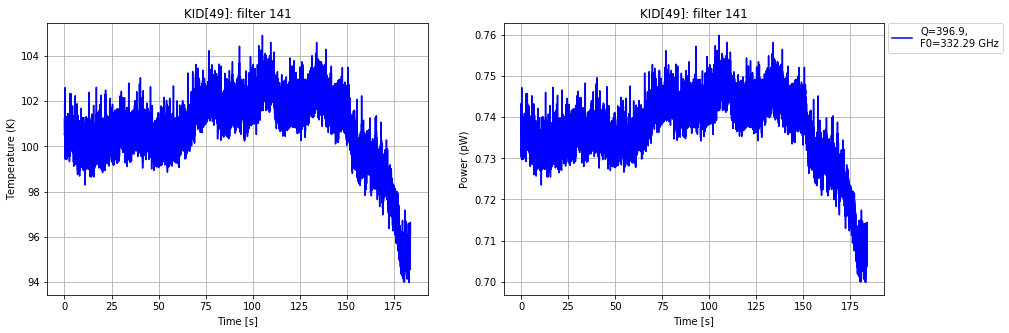

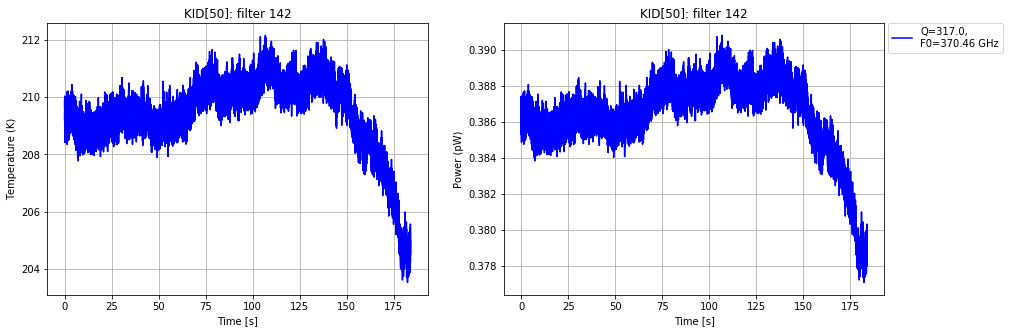

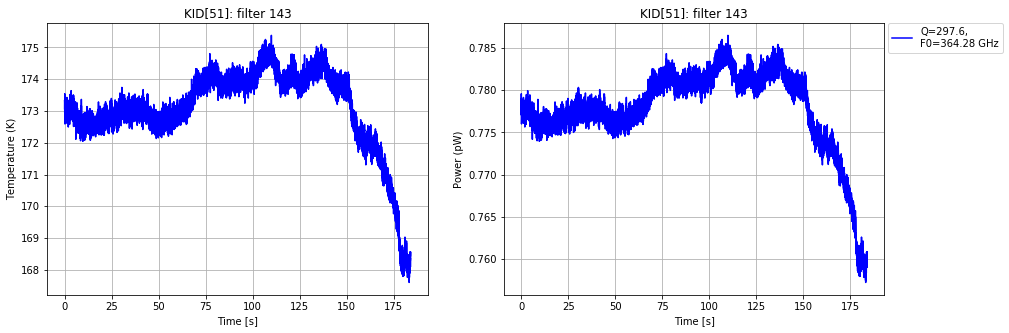

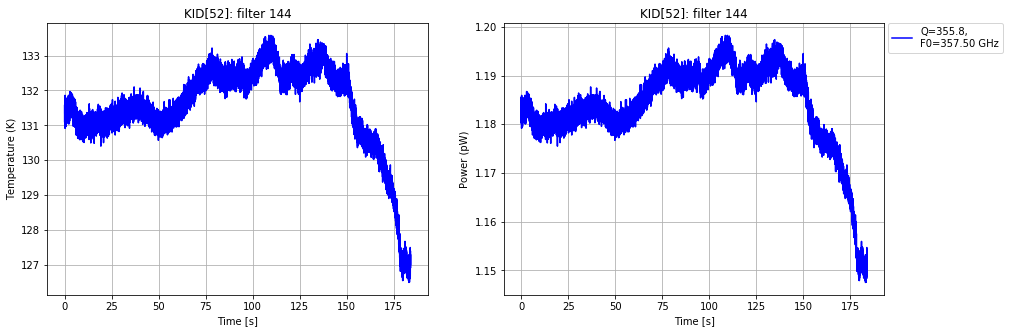

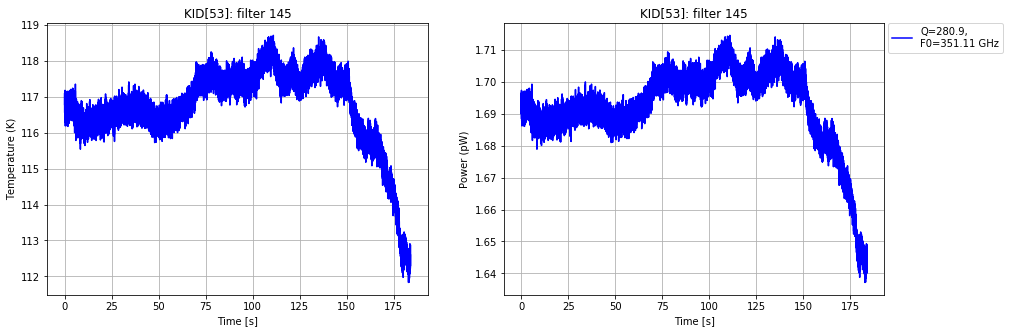

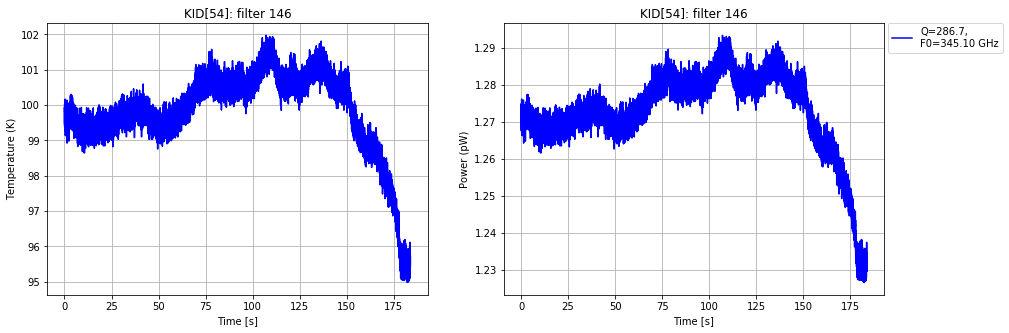

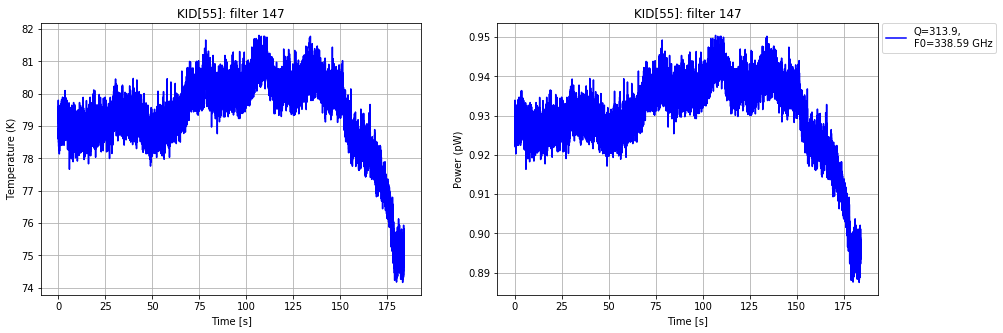

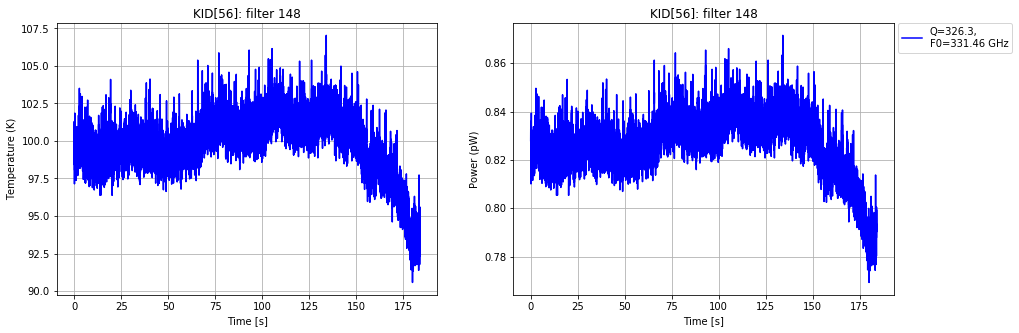

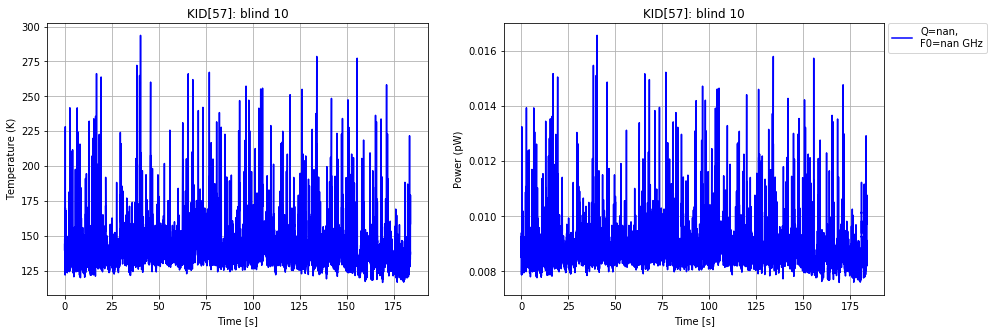

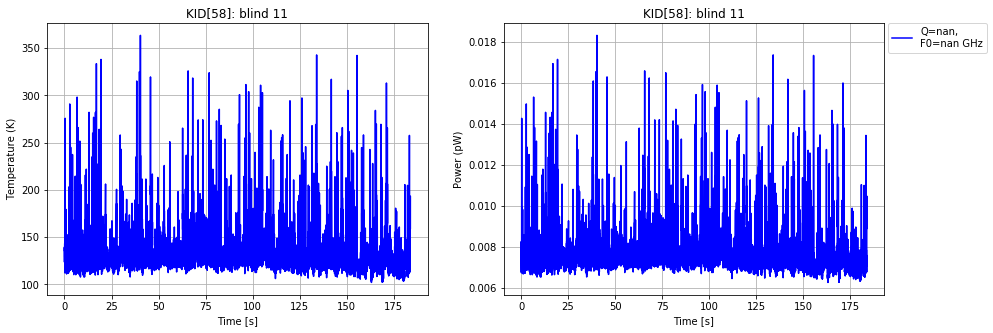

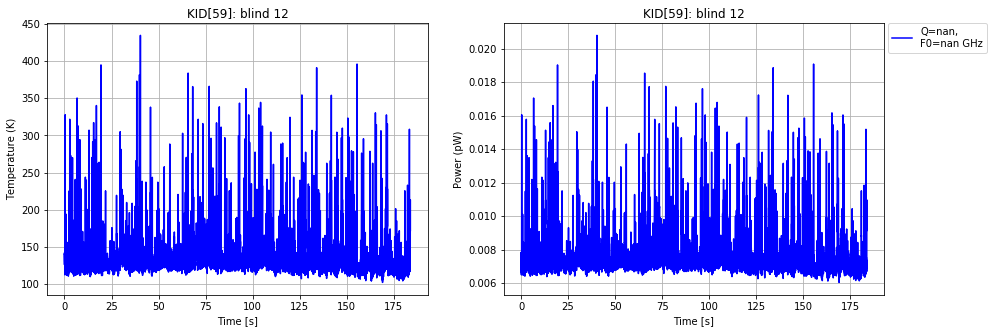

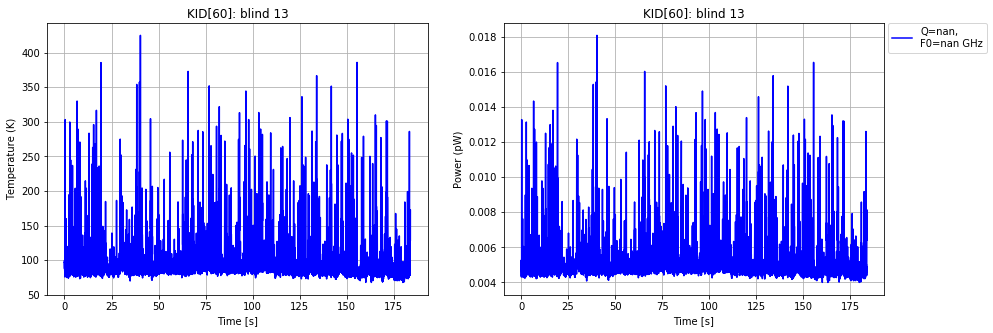

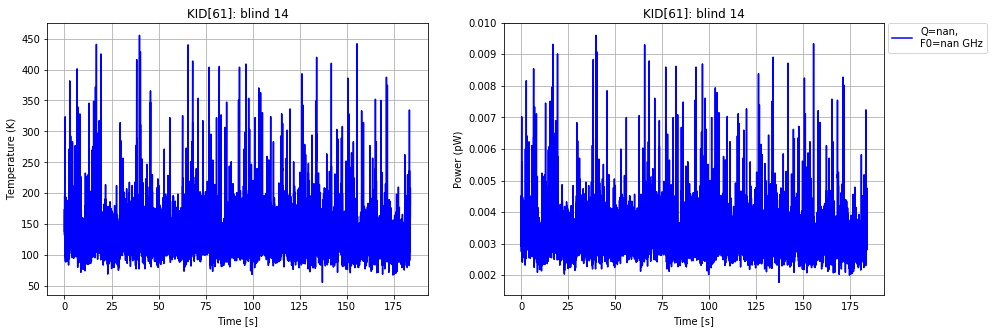

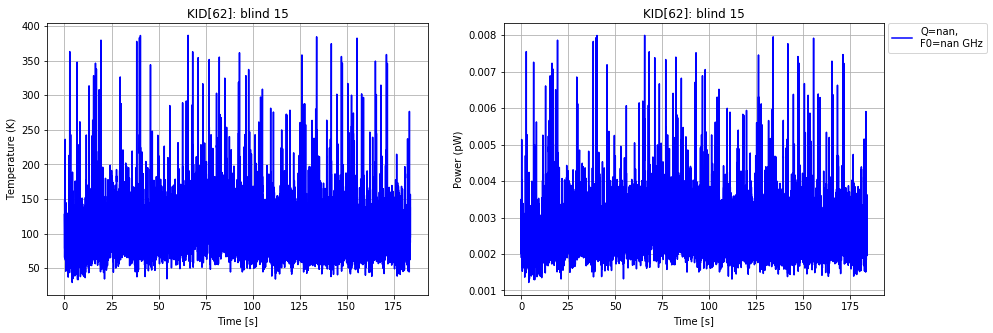

In [6]:
nkid = rhdus['READOUT'].header['NKID%d' %pixelid]
disabled = [16,]
#disabled = [16, 18]

kidid, Fmeas, Tmeas, Pmeas = [], [], [], []
idx_filter = []
for i in range(nkid):
    masterid = kiddict[i]
    if masterid<0: continue
    if i in disabled: continue
    kind = kidname[masterid]
    
    ts = rhdus['READOUT'].data['timestamp']
    temp = Tsignal[i]
    power = Psignal[i]
    if temp[0]!=temp[0]:
        disabled.append(i)
        print('disabled: %d' %i)
        continue
    
    if kind=='filter':
        F0, dF0 = ddb['KIDFILT'].data['F_filter, dF_filter'][i]
        Q, dQ = ddb['KIDFILT'].data['Q_filter, dQ_filter'][i]
        idx_filter.append(True)
    else:
        F0, dF0, Q, dQ = (np.nan, np.nan, np.nan, np.nan)
        idx_filter.append(False)
    
    kidid.append(i)
    #Fmeas.append( (F0, dF0) )
    Fmeas.append( (F0, F0/Q) )
    Tmeas.append( (np.average(temp), np.std(temp)) )
    Pmeas.append( (np.average(power), np.std(power)) )
    
    ts = ts - ts[0]
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].set_title('KID[%d]: %s %d' %(i, kind, masterid))
    ax[0].plot(ts, temp, 'b')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Temperature (K)')
    ax[0].grid()
    ax[0].legend(loc='best')
    
    ax[1].set_title('KID[%d]: %s %d' %(i, kind, masterid))
    ax[1].plot(ts, power*1e+12, 'b', label='Q=%.1f,\nF0=%.2f GHz' %(Q, F0))
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Power (pW)')
    ax[1].grid()
    #ax[1].legend(loc='best')
    ax[1].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [7]:
def draw_spectrum(kind):
    logscale = False
    if kind=='Temperature':
        v = abs( np.array(Tmeas).T[0] )
        v_err = np.array(Tmeas).T[1]
    elif kind=='Power':
        v = abs( np.array(Pmeas).T[0] )
        v_err = np.array(Pmeas).T[1]
        logscale = True
    else:
        print( 'No such kind: %s' %kind )
        return 0
        
    print( len(v), len(v[idx_filter]) )

    ## draw
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].errorbar(kidid, v, yerr=v_err, fmt='o')
    ax[0].grid()
    if logscale: ax[0].set_yscale('log')
    ax[0].set_title(kind)
    ax[0].set_xlabel('KID ID')

    x = np.array(Fmeas).T[0]
    x_err = np.array(Fmeas).T[1]

    sortidx = np.argsort(x[idx_filter])

    ax[1].errorbar(x[idx_filter][sortidx], v[idx_filter][sortidx],
                   xerr=x_err[idx_filter][sortidx], yerr=v_err[idx_filter][sortidx],
                   fmt='o', label='measured')
    ax[1].step(x[idx_filter][sortidx]+x_err[idx_filter][sortidx]/2., v[idx_filter][sortidx])

    ax[1].grid()
    if logscale: ax[1].set_yscale('log')
    ax[1].set_title(kind)
    ax[1].set_xlabel('F filter meas. [GHz]')
    ax[1].legend(loc='best')
    
    return fig,ax

60 47
60 47


(<matplotlib.figure.Figure at 0x12c28a8d0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x12c28af60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12c2c2d68>], dtype=object))

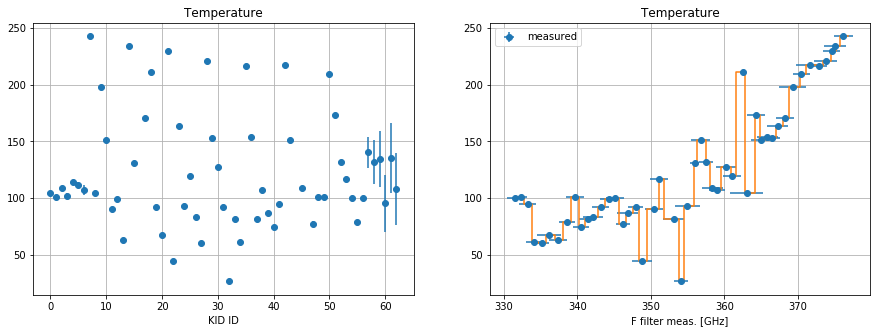

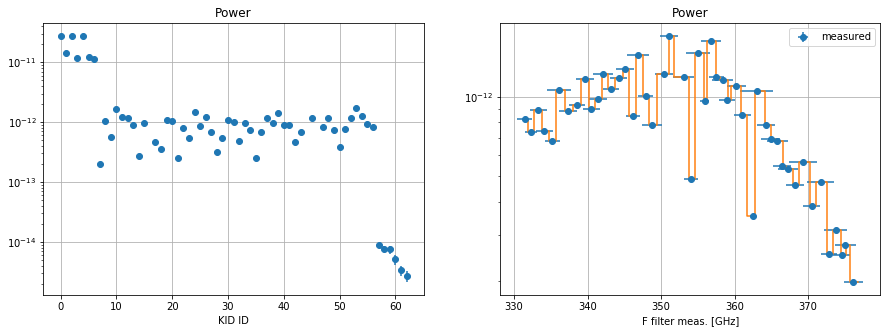

In [8]:
draw_spectrum('Temperature')
draw_spectrum('Power')

In [9]:
atmdata = ascii.read('punt3tot1punt5.data')

attributes = ['Freq.', 'PWV=0.3', 'PWV=0.5', 'PWV=0.75', 'PWV=1.00', 'PWV=1.5']
for i, att in enumerate(attributes):
    atmdata.rename_column('col%d' %(i+1), att)

atmdata.colnames

['Freq.', 'PWV=0.3', 'PWV=0.5', 'PWV=0.75', 'PWV=1.00', 'PWV=1.5']

{'Freq.': None, 'PWV=0.3': '#1f77b4', 'PWV=0.5': '#ff7f0e', 'PWV=0.75': '#2ca02c', 'PWV=1.00': '#d62728', 'PWV=1.5': '#9467bd'}
60 47


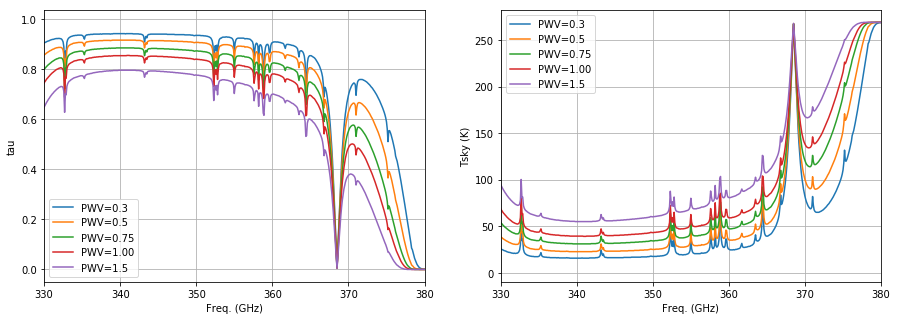

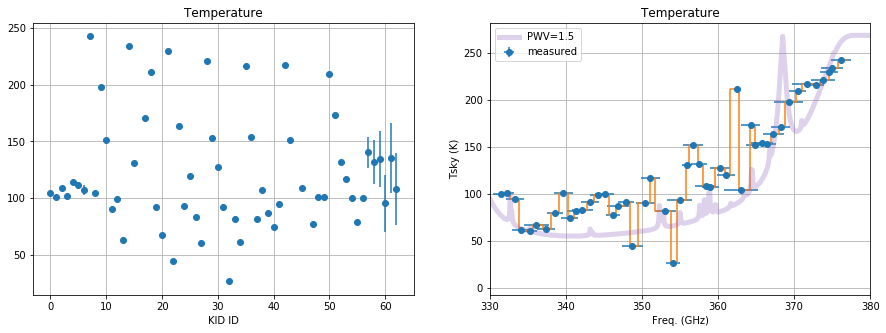

In [10]:
Tamb = 269. # K

x = atmdata[attributes[0]]

plotcol = { attributes[0]:None }
fig, ax = plt.subplots(1,2, figsize=(15,5))
for i, att in enumerate(attributes):
    if i==0: continue

    y = atmdata[att]
    Tsky = (1.-y)*Tamb 
   
    tmp = ax[0].plot(x, y, '-', label=att)
    plotcol[att] = tmp[0].get_color()
    ax[1].plot(x, Tsky, '-', label=att)

ax[0].set_xlabel('%s (GHz)' %attributes[0])
ax[0].set_ylabel('tau')
ax[0].set_xlim(330., 380.)
ax[0].grid()
ax[0].legend(loc='best')

ax[1].set_xlabel('%s (GHz)' %attributes[0])
ax[1].set_ylabel('Tsky (K)')
ax[1].set_xlim(330., 380.)
ax[1].grid()
ax[1].legend(loc='best')

print( plotcol )

fig, ax = draw_spectrum('Temperature')
att = 'PWV=1.5'
Tsky = (1.-atmdata[att])*Tamb 
ax[1].plot(x, Tsky, '-', lw=5, alpha=0.3, color=plotcol[att], label=att)

ax[1].set_xlabel('%s (GHz)' %attributes[0])
ax[1].set_ylabel('Tsky (K)')
ax[1].set_xlim(330., 380.)
#ax[1].grid()
ax[1].legend(loc='best')